In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch_nn import SensorsDataModule, LSTMRegressor, mse_seq

In [2]:
model = LSTMRegressor.load_from_checkpoint(checkpoint_path='./lstm_rot6D/best.ckpt')
model.cuda()

torch.set_grad_enabled(False)
model.eval()

LSTMRegressor(
  (lstm): LSTM(12, 100, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=100, out_features=6, bias=True)
  (tanh): Tanh()
)

In [3]:
from tools import *

In [4]:
# body_part = "head"
# file_names = ['./data/training_data/head_data_1.log',
#              './data/training_data/head_data_2.log',
#              './data/training_data/head_data_3.log',
#              './data/training_data/head_data_4.log',
#              './data/training_data/head_data_5.log',
#              './data/training_data/head_data_6.log']

body_part = "shoulder_right"
file_names = [
             './data/training_data/shoulder_right_data_6.log',
             './data/training_data/shoulder_right_data_7.log',
             './data/training_data/shoulder_right_data_8.log',
             './data/training_data/shoulder_right_data_9.log',
             './data/training_data/shoulder_right_data_14.log',
             './data/training_data/shoulder_right_data_15.log',
             './data/training_data/shoulder_right_data_16.log',
             './data/training_data/shoulder_right_data_17.log']

# body_part = "shoulder_left"
# file_names = ['./data/training_data/shoulder_left_data_1.log',
#               './data/training_data/shoulder_left_data_2.log',
#               './data/training_data/shoulder_left_data_3.log']

dataset = [pd.read_csv(f, delim_whitespace=True, header=0) for f in file_names]
# dataset = [data[(np.abs(stats.zscore(data[["mx0", "my0", "mz0"]])) < 2.75).all(axis=1)] for data in dataset]
# dataset = [data[(np.abs(stats.zscore(data[["mx1", "my1", "mz1"]])) < 2.75).all(axis=1)] for data in dataset]
# dataset = [data[(np.abs(stats.zscore(data[["mx2", "my2", "mz3"]])) < 2.75).all(axis=1)] for data in dataset]
# dataset = [data[(np.abs(stats.zscore(data[["mx3", "my3", "mz3.1"]])) < 2.75).all(axis=1)] for data in dataset]
dataset = [data[(np.abs(stats.zscore(data[["roll", "pitch", "yaw"]])) < 2.75).all(axis=1)] for data in dataset]
dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset)

print('%d values'%(len(dataset)))

346086 values


In [5]:
dataset = dataset.values[1:len(dataset)-1,0:]
# np.random.shuffle(dataset)

dataset = dataset[abs(dataset[:,12])!=0.0,:]
dataset = dataset[abs(dataset[:,13])!=0.0,:]
dataset = dataset[abs(dataset[:,14])!=0.0,:]
print('%d values after filtering outliers'%(len(dataset)))

euler_set = dataset[:, 12:15]
print('max euler ' + str(np.amax(euler_set)))
print('min euler ' + str(np.amin(euler_set)))
sensors_set = dataset[:, :12]

346084 values after filtering outliers
max euler 1.411555809406252
min euler -2.2710370734661414


In [6]:
sensors_scaler = MinMaxScaler(feature_range=(-1., 1.))
sensors_set = sensors_scaler.fit_transform(sensors_set)

In [7]:
device = "cuda"

In [8]:
start_idx = 205111
end_idx = 206511
test_idxs = slice(start_idx, end_idx)

In [9]:
in_set = []

look_back = 3
for i in range(start_idx, end_idx):
    in_set.append(sensors_set[i:i+look_back] + np.random.normal(size=(look_back, 12))*0.0)

in_set = torch.tensor(in_set, dtype=torch.float32).to(device)

In [10]:
out_set = model(in_set)[:, -1]#.view(-1, 3, 3)
rot_pred = compute_rotation_matrix_from_ortho6d(out_set)
euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred).cpu().detach().numpy()

In [11]:
euler_plt = euler_pred[150:870] 

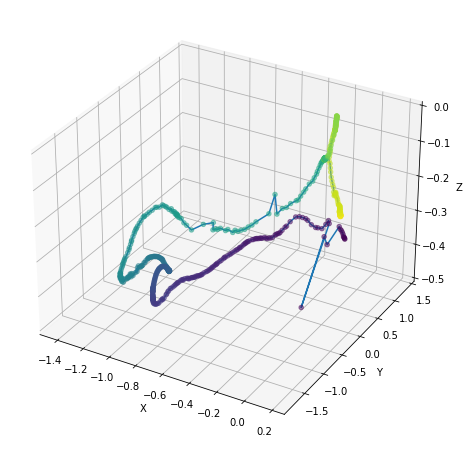

In [12]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1, 1, 1, projection='3d')
sc = ax.plot(euler_plt[:,0], euler_plt[:,1], euler_plt[:,2]) #, c=np.arange(len(euler_plt)), alpha=0.5)
sc = ax.scatter(euler_plt[:,0], euler_plt[:,1], euler_plt[:,2], c=np.arange(len(euler_plt)), alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([-1.5, 0.25])
ax.set_ylim([-1.95, 1.5])
ax.set_zlim([-0.5, 0.0])

# plt.colorbar(sc)
plt.show()